In [12]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../..')))

In [13]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [14]:
kernel = 3
hidden = 30
sigma_min = 0.005
sigma_max = 0.1

In [15]:
data_dir = f'../savings/lpn_cond_mrs_h_{hidden}_k_{kernel}_n_({sigma_min}_{sigma_max})/denoise/0.03/'
x_noisy = np.load(f'{data_dir}/x_noisy.npy')
y_LPN = np.load(f'{data_dir}/y_LPN_cond.npy')
y_wv = np.load(f'{data_dir}/y_wv.npy')
gt = np.load(f'{data_dir}/../gt.npy')
print(gt.shape)

(30, 512)


In [16]:
ppm_min = 0.578848480483455
ppm_max = 4.49271535465395
num_points = 512
x_axis = np.linspace(ppm_min, ppm_max, num_points)
x_range_indices = slice(0, 512)
x_range_values = x_axis[x_range_indices]

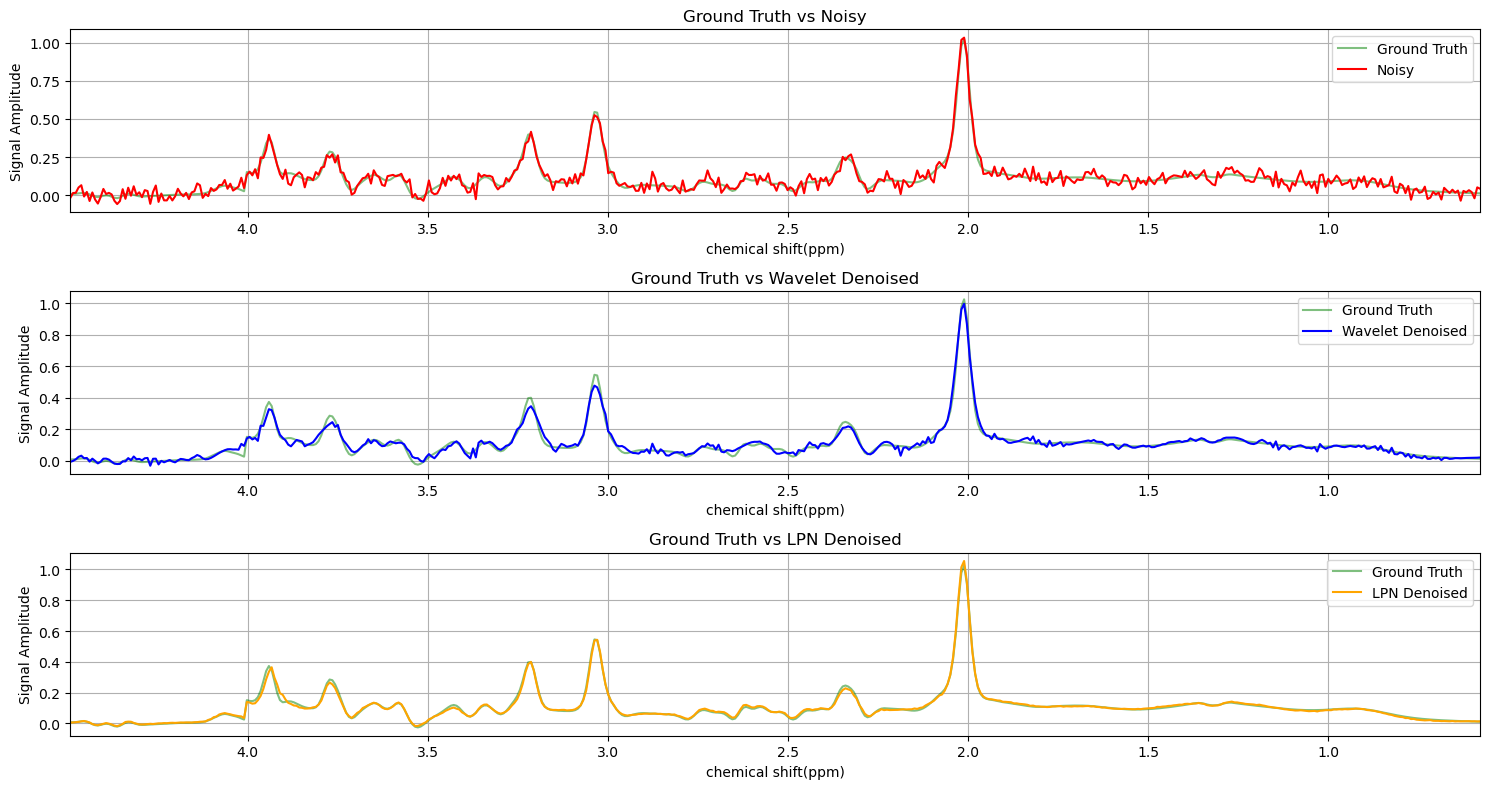

In [17]:
sample_index = 0  # Change as needed

fig, axs = plt.subplots(3, 1, figsize=(15, 8))

# First row: GT and noisy
axs[0].plot(x_range_values, gt[sample_index,x_range_indices], label='Ground Truth', color='green', alpha = 0.5)
axs[0].plot(x_range_values, x_noisy[sample_index,x_range_indices], label='Noisy', color='red')
axs[0].set_title('Ground Truth vs Noisy')
axs[0].set_ylabel('Signal Amplitude')
axs[0].set_xlabel('chemical shift(ppm)')
axs[0].set_xlim(x_range_values[0], x_range_values[-1])
axs[0].invert_xaxis()
axs[0].legend()
axs[0].grid()

# Second row: GT and wavelet denoised
axs[1].plot(x_range_values, gt[sample_index,x_range_indices], label='Ground Truth', color='green', alpha = 0.5)
axs[1].plot(x_range_values, y_wv[sample_index,x_range_indices], label='Wavelet Denoised', color='blue')
axs[1].set_title('Ground Truth vs Wavelet Denoised')
axs[1].set_ylabel('Signal Amplitude')
axs[1].set_xlabel('chemical shift(ppm)')
axs[1].set_xlim(x_range_values[0], x_range_values[-1])
axs[1].invert_xaxis()
axs[1].legend()
axs[1].grid()

# Third row: GT and LPN denoised
axs[2].plot(x_range_values, gt[sample_index,x_range_indices], label='Ground Truth', color='green', alpha = 0.5)
axs[2].plot(x_range_values, y_LPN[sample_index,x_range_indices], label='LPN Denoised', color='orange')
axs[2].set_title('Ground Truth vs LPN Denoised')
axs[2].set_ylabel('Signal Amplitude')
axs[2].set_xlabel('chemical shift(ppm)')
axs[2].set_xlim(x_range_values[0], x_range_values[-1])
axs[2].invert_xaxis()
axs[2].legend()
axs[2].grid()

# Adjust layout for subplots
plt.tight_layout()
plt.show()

In [18]:
lpn_cond_h30_k3 = pd.read_csv('../savings/lpn_cond_mrs_h_30_k_3_n_(0.005_0.1)/denoise/LPN_cond_denoise.csv')
lpn_h30_k3 = pd.read_csv('../savings/lpn_mrs_h_30_k_3_n_(0.005_0.1)/denoise/LPN_denoise.csv')
lpn_h30_k3_nfix = pd.read_csv('../savings/lpn_mrs_h_30_k_3_n_(0.01_0.01)/denoise/LPN_denoise.csv')
wv = pd.read_csv('../savings/lpn_mrs_h_30_k_3_n_(0.005_0.1)/denoise/wv_denoise.csv')

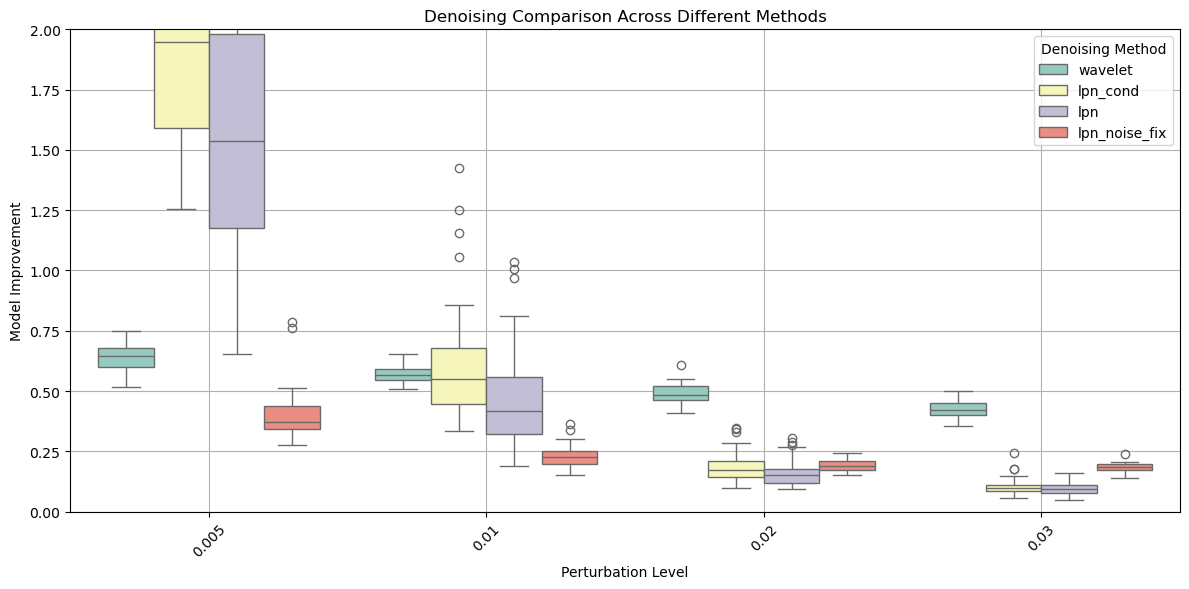

In [19]:
lpn_cond_h30_k3['method'] = 'lpn_cond'
lpn_h30_k3['method'] = 'lpn'
lpn_h30_k3_nfix['method'] = 'lpn_noise_fix'
wv['method'] = 'wavelet'

combined_df = pd.concat([wv, lpn_cond_h30_k3, lpn_h30_k3, lpn_h30_k3_nfix], ignore_index=True)
melted_df = combined_df.melt(id_vars='method', var_name='perturbation', value_name='Improvement')

plt.figure(figsize=(12, 6))
sns.boxplot(x='perturbation', y='Improvement', hue='method', data=melted_df, palette='Set3')
plt.title('Denoising Comparison Across Different Methods')
plt.xlabel('Perturbation Level')
plt.ylabel('Model Improvement')
plt.ylim((0,2))
plt.legend(title='Denoising Method')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()